In [2]:
import pandas as pd
import numpy as np

In [3]:
from glob import glob
from pprint import pprint
import dill
import json

In [277]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
import bokeh.palettes as bpal
from bokeh.models import CategoricalColorMapper
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.models import Legend, LinearAxis, Range1d, DatetimeTickFormatter
from bokeh.io import export_png
output_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [5]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
def make_plotgrid(totalrange, ncols):
    """for feeding into bokeh griplot, returns array of rows/columns"""
    nrows = int(np.ceil(totalrange/ncols))
    feeder = iter(range(totalrange))
    plotgrid = [[]]*nrows
    for r in range(nrows):
        thisrow = []
        for c in range(ncols):
            try:
                thisrow.append(next(feeder))
            except:
                thisrow.append(None)
        plotgrid[r] = thisrow
    return plotgrid

In [7]:
def draw_gridplot(indf, columns='first', ncols=3, total_width=900, each_height=300, incolours = ['blue','red','yellow','green','purple','orange']):
    """Grid plots by month in bokeh
    Requires:
    > indf has datetime index
    > if columns are left unspecified (should be a list of col names), then just first column is plotted
    > only takes up to 6 columns, then runs out of colours to plot unless you put more into incolours"""
    if columns == 'first':
        columns = [indf.columns[0]]
    else:
        pass
    indf['Month'] = indf.index.month
    indf['mthname'] = indf.index.month_name()
    
    each_width = int(total_width/ncols)
    
    clrcols = [(col, clr) for col, clr in zip(columns, incolours)]
    dictmonth = {}
    
    for no,mth in enumerate(indf.mthname.unique()):
        dictmonth[no] = figure(plot_width=each_width, plot_height=each_height, title=mth, x_axis_type='datetime')
        for col, clr in clrcols:
            dictmonth[no].line(indf.index[indf.Month == no+1], indf[col][indf.Month == no+1], line_width=1, color = clr)
    
    plotgrid = make_plotgrid(len(indf.mthname.unique()), ncols=ncols)
    for row in range(len(plotgrid)):
        for p in range(len(plotgrid[row])):
            plotgrid[row][p] = dictmonth[plotgrid[row][p]]
    
    the_grid = gridplot(plotgrid)
    show(the_grid)
    return the_grid

In [8]:
feat_files = glob('../data/ready-for-model/*.csv')
feat_files

['../data/ready-for-model/2009-18_NEMtotaldemand.csv',
 '../data/ready-for-model/20190226_SAdf_features.csv',
 '../data/ready-for-model/20190226_TASdf_features.csv',
 '../data/ready-for-model/20190226_NSWdf_features.csv',
 '../data/ready-for-model/20190226_VICdf_features.csv',
 '../data/ready-for-model/20190226_QLDdf_features.csv']

In [19]:
fvic = glob('../data/ready-for-model/*VIC*.csv')[0]
fvic

'../data/ready-for-model/20190226_VICdf_features.csv'

In [14]:
ftarget = feat_files[0]
ftarget

'../data/ready-for-model/2009-18_NEMtotaldemand.csv'

In [15]:
dftarget = pd.read_csv(ftarget, index_col=0, parse_dates=[0])
dftarget.head(3)

,NSW1,QLD1,SA1,TAS1,VIC1,NEMtotal
SETTLEMENTDATE,,,,,,
2009-01-01 00:30:00,7535.00,5611.54,1310.89,909.71,4799.87,20167.01
2009-01-01 01:00:00,7229.24,5457.34,1272.69,896.63,4646.21,19502.11
2009-01-01 01:30:00,6857.62,5294.12,1178.87,897.52,4950.16,19178.29


In [18]:
target = dftarget[['VIC1']][dftarget.index.year == 2018]
target.head(3)

,VIC1
SETTLEMENTDATE,
2018-01-01 00:00:00,4445.07
2018-01-01 00:30:00,4251.18
2018-01-01 01:00:00,4092.53


In [21]:
dfvic = pd.read_csv(fvic, index_col=0, parse_dates=[0])
dfvic.head()

,Date,Hour_of_day,Year,shoulder,summer,winter,workdayVIC,MILDURA-AIRPORT_MinT_76031,CAPE-NELSON_MaxT_90184,MORWELL_MaxT_85280,MELBOURNE-AIRPORT_MinT_86282,CAPE-NELSON_MinT_90184,MILDURA-AIRPORT_MaxT_76031,MELBOURNE-AIRPORT_MaxT_86282,MORWELL_MinT_85280
SETTLEMENTDATE,,,,,,,,,,,,,,,
2009-01-01 00:30:00,2009-01-01,0.5,2009,0,1,0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4
2009-01-01 01:00:00,2009-01-01,1.0,2009,0,1,0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4
2009-01-01 01:30:00,2009-01-01,1.5,2009,0,1,0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4
2009-01-01 02:00:00,2009-01-01,2.0,2009,0,1,0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4
2009-01-01 02:30:00,2009-01-01,2.5,2009,0,1,0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4


In [23]:
dfvic.isnull().sum()

Date                              0
Hour_of_day                       0
Year                              0
shoulder                          0
summer                            0
winter                            0
workdayVIC                        1
MILDURA-AIRPORT_MinT_76031        0
CAPE-NELSON_MaxT_90184          144
MORWELL_MaxT_85280              144
MELBOURNE-AIRPORT_MinT_86282      0
CAPE-NELSON_MinT_90184          144
MILDURA-AIRPORT_MaxT_76031        0
MELBOURNE-AIRPORT_MaxT_86282      0
MORWELL_MinT_85280              144
dtype: int64

In [25]:
dfmerged = pd.merge(dfvic, target, how='left', left_index=True, right_index=True)
dfmerged.dropna(inplace=True)
dfmerged.head(3)

,Date,Hour_of_day,Year,shoulder,summer,winter,workdayVIC,MILDURA-AIRPORT_MinT_76031,CAPE-NELSON_MaxT_90184,MORWELL_MaxT_85280,MELBOURNE-AIRPORT_MinT_86282,CAPE-NELSON_MinT_90184,MILDURA-AIRPORT_MaxT_76031,MELBOURNE-AIRPORT_MaxT_86282,MORWELL_MinT_85280,VIC1
SETTLEMENTDATE,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,2018-01-01,0.0,2018,0,1,0,0.0,14.3,21.1,26.2,14.0,14.9,31.7,26.2,15.5,4445.07
2018-01-01 00:30:00,2018-01-01,0.5,2018,0,1,0,0.0,14.3,21.1,26.2,14.0,14.9,31.7,26.2,15.5,4251.18
2018-01-01 01:00:00,2018-01-01,1.0,2018,0,1,0,0.0,14.3,21.1,26.2,14.0,14.9,31.7,26.2,15.5,4092.53


In [62]:
target = dfmerged[['VIC1']].copy()

<Figure size 432x288 with 0 Axes>

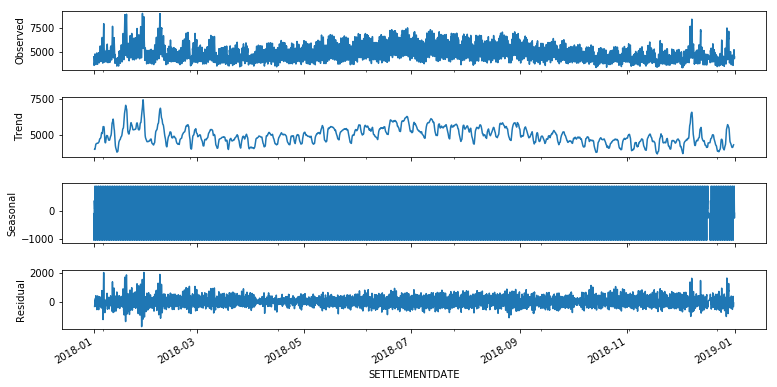

In [63]:
daily = seasonal_decompose(target.VIC1, freq = 48)
fig = plt.figure()  
fig = daily.plot()  
fig.set_size_inches(12, 6)
plt.show()

In [64]:
target['dtrend'] = daily.trend.values
target['dseason'] = daily.seasonal.values
target['dresid'] = daily.resid.values
target.head()

,VIC1,dtrend,dseason,dresid
SETTLEMENTDATE,,,,
2018-01-01 00:00:00,4445.07,NaN,-108.685311,NaN
2018-01-01 00:30:00,4251.18,NaN,-319.627541,NaN
2018-01-01 01:00:00,4092.53,NaN,-479.833620,NaN
2018-01-01 01:30:00,3958.95,NaN,-605.135523,NaN
2018-01-01 02:00:00,3785.27,NaN,-768.960058,NaN


In [65]:
target['d_unexp'] = target.dtrend + target.dresid
target.dropna(inplace=True)
target.head(3)

,VIC1,dtrend,dseason,dresid,d_unexp
SETTLEMENTDATE,,,,,
2018-01-01 12:00:00,3725.76,3997.198333,73.530107,-344.96844,3652.229893
2018-01-01 12:30:00,3727.86,3994.688229,58.307511,-325.13574,3669.552489
2018-01-01 13:00:00,3757.85,3992.120000,52.900720,-287.17072,3704.949280


<Figure size 432x288 with 0 Axes>

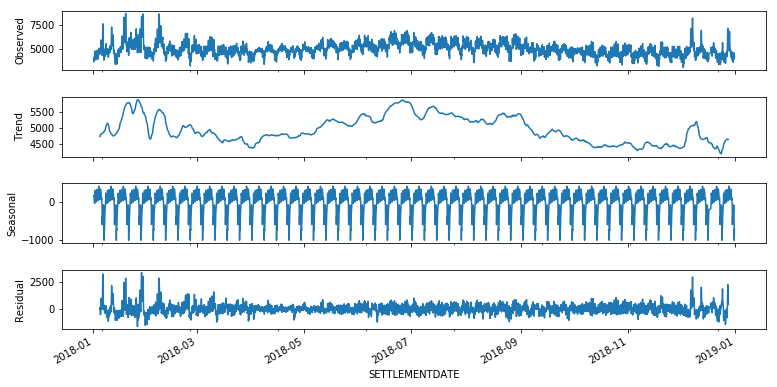

In [66]:
weekly = seasonal_decompose(target.d_unexp, freq = 48*7)
fig = plt.figure()  
fig = weekly.plot()  
fig.set_size_inches(12, 6)

In [67]:
target['wtrend'] = weekly.trend.values
target['wseason'] = weekly.seasonal.values
target['wresid'] = weekly.resid.values

In [68]:
target.dropna(inplace=True)
target.head()

,VIC1,dtrend,dseason,dresid,d_unexp,wtrend,wseason,wresid
SETTLEMENTDATE,,,,,,,,
2018-01-05 00:00:00,4666.70,4797.958229,-108.685311,-22.572918,4775.385311,4741.670997,106.085841,-72.371527
2018-01-05 00:30:00,4438.29,4804.423229,-319.627541,-46.505689,4757.917541,4746.690640,87.711107,-76.484207
2018-01-05 01:00:00,4315.74,4811.848229,-479.833620,-16.274609,4795.573620,4751.889137,82.108924,-38.424441
2018-01-05 01:30:00,4230.84,4819.719896,-605.135523,16.255627,4835.975523,4757.222292,73.309478,5.443753
2018-01-05 02:00:00,4082.17,4828.386042,-768.960058,22.744016,4851.130058,4762.404033,75.481916,13.244109


In [72]:
def stacked(df):
    df_top = df.cumsum(axis=1)
    df_bottom = df_top.shift(axis=1).fillna({'y0': 0})[::-1]
    df_stack = pd.concat([df_bottom, df_top], ignore_index=True)
    return df_stack

In [96]:
# target[['wtrend', 'wseason', 'dseason', 'wresid']].cumsum(axis=1).shift(axis=1).fillna({'y0': 0})[::-1]

In [74]:
areas = stacked(target[['wtrend', 'wseason', 'dseason', 'wresid']])

In [95]:
# areas

In [94]:
# x2 = np.hstack((target.index[::-1], target.index))

In [93]:
# x2

In [92]:
# p = figure(x_range=(min(x2), max(x2)), y_range=(0, 8000), x_axis_type='datetime', plot_width = 900, plot_height = 500)
# p.grid.minor_grid_line_color = '#eeeeee'

# p.patches([x2] * areas.shape[1], [areas[c].values for c in areas],
#           alpha=0.8, line_color=None)

# show(p)

In [100]:
target['Total'] = target[['dseason','wtrend','wseason','wresid']].sum(axis=1)

In [101]:
target[abs(target.VIC1 - target.Total) > 0.001]

,VIC1,dtrend,dseason,dresid,d_unexp,wtrend,wseason,wresid,Total
SETTLEMENTDATE,,,,,,,,,


In [216]:
vfeatures.head(2)

,Hour_of_day,shoulder,summer,winter,workdayVIC,MILDURA-AIRPORT_MinT_76031,CAPE-NELSON_MaxT_90184,MORWELL_MaxT_85280,MELBOURNE-AIRPORT_MinT_86282,CAPE-NELSON_MinT_90184,MILDURA-AIRPORT_MaxT_76031,MELBOURNE-AIRPORT_MaxT_86282,MORWELL_MinT_85280
SETTLEMENTDATE,,,,,,,,,,,,,
2018-02-21 03:00:00,3.0,0,1,0,1.0,22.9,20.1,27.8,13.8,17.3,35.4,29.3,11.5
2018-02-21 03:30:00,3.5,0,1,0,1.0,22.9,20.1,27.8,13.8,17.3,35.4,29.3,11.5


In [218]:
dfvic[dfvic.index.isin(target.index)].head()

,Date,Hour_of_day,Year,shoulder,summer,winter,workdayVIC,MILDURA-AIRPORT_MinT_76031,CAPE-NELSON_MaxT_90184,MORWELL_MaxT_85280,MELBOURNE-AIRPORT_MinT_86282,CAPE-NELSON_MinT_90184,MILDURA-AIRPORT_MaxT_76031,MELBOURNE-AIRPORT_MaxT_86282,MORWELL_MinT_85280
SETTLEMENTDATE,,,,,,,,,,,,,,,
2018-01-05 00:00:00,2018-01-05,0.0,2018,0,1,0,1.0,18.4,31.2,30.5,12.2,15.0,39.1,30.5,11.1
2018-01-05 00:30:00,2018-01-05,0.5,2018,0,1,0,1.0,18.4,31.2,30.5,12.2,15.0,39.1,30.5,11.1
2018-01-05 01:00:00,2018-01-05,1.0,2018,0,1,0,1.0,18.4,31.2,30.5,12.2,15.0,39.1,30.5,11.1
2018-01-05 01:30:00,2018-01-05,1.5,2018,0,1,0,1.0,18.4,31.2,30.5,12.2,15.0,39.1,30.5,11.1
2018-01-05 02:00:00,2018-01-05,2.0,2018,0,1,0,1.0,18.4,31.2,30.5,12.2,15.0,39.1,30.5,11.1


In [322]:
dtformats = DatetimeTickFormatter(microseconds = ['%fus'],
milliseconds = ['%3Nms', '%S.%3Ns'],
seconds = ['%Ss'],
minsec = [':%M:%S'],
minutes = [':%M', '%Mm'],
hourmin = ['%H:%M'],
hours = ['%Hh', '%H:%M'],
days = ['%d/%m', '%a%d'],
months = ['%m/%Y', '%b %Y'],
years = ['%Y'])

In [294]:
v = figure(plot_height = 400, plot_width = 850, x_axis_type = 'datetime')

v.extra_y_ranges = {'temp' : Range1d(start=0, end=45)}
v.xaxis.formatter = dtformats
v.add_layout(LinearAxis(y_range_name='temp'), 'right')
v.line(target.index, target.VIC1, color = 'purple')
v.line(target.index, dfvic['MELBOURNE-AIRPORT_MaxT_86282'][dfvic.index.isin(target.index)], color = 'orange', y_range_name='temp')
v.line(target.index, dfvic['MELBOURNE-AIRPORT_MinT_86282'][dfvic.index.isin(target.index)], color = 'aqua', y_range_name='temp')
v.vbar(target.index - pd.to_timedelta(15, unit='m'), width=pd.to_timedelta(30, unit='m'), 
       top=dfvic['workdayVIC'][dfvic.index.isin(target.index)]*100, fill_alpha=0.3, fill_color = 'green', 
       line_alpha=0, y_range_name='temp')

show(v)

In [354]:
z = figure(plot_height = 400, plot_width = 850, x_axis_type = 'datetime')

srange = pd.to_datetime('20-4-2018', dayfirst=True)
erange = pd.to_datetime('24-4-2018', dayfirst=True)

myfontsize = '14pt'
labelfont = '18pt'

z.x_range.start = srange
z.x_range.end   = erange
z.y_range.start = 2000
z.y_range.end   = 6500
z.yaxis.major_label_text_font_size = myfontsize
z.xaxis.major_label_text_font_size = myfontsize
z.xaxis.formatter = dtformats

z.yaxis.axis_label = 'Electricity Demand (MW)'
z.yaxis.axis_label_text_font_size = labelfont
z.yaxis.axis_label_standoff = 20


z.extra_y_ranges = {'temp' : Range1d(start=0, end=45)}
z.add_layout(LinearAxis(y_range_name='temp', major_label_text_font_size=myfontsize, 
                        axis_label='Temperature (Min/Max) - deg C', axis_label_text_font_size=labelfont, axis_label_standoff = 20)
             , 'right')

# Elec Demand
z.line(target.index, target.VIC1, color = 'purple', line_width=3)

# # # Melb max temp
# z.line(target.index, dfvic['MELBOURNE-AIRPORT_MaxT_86282'][dfvic.index.isin(target.index)], color = 'orange', 
#        y_range_name='temp', line_width=1.5, legend='Daily Max Temp (Melb Airport)')
# # # Melb min temp
# z.line(target.index, dfvic['MELBOURNE-AIRPORT_MinT_86282'][dfvic.index.isin(target.index)], color = 'aqua', 
#        y_range_name='temp', line_width=1.5, legend='Daily Min Temp (Melb Airport)')

# is workday
workx = target.index + pd.to_timedelta(15, unit='m')
worky = dfvic['workdayVIC'][dfvic.index.isin(target.index)]*100
z.vbar(workx, width=pd.to_timedelta(30, unit='m'), top=worky, fill_alpha=0.3, fill_color = 'green', line_alpha=0, y_range_name='temp', legend='Is a workday')

z.legend.location = 'top_center'
z.legend.label_text_font_size = '12pt'

show(z)

In [307]:
target['Time'] = target.index.time
target.head()

,VIC1,dtrend,dseason,dresid,d_unexp,wtrend,wseason,wresid,Total,Month,mthname,Time
SETTLEMENTDATE,,,,,,,,,,,,
2018-01-05 00:00:00,4666.70,4797.958229,-108.685311,-22.572918,4775.385311,4741.670997,106.085841,-72.371527,4666.70,1,January,00:00:00
2018-01-05 00:30:00,4438.29,4804.423229,-319.627541,-46.505689,4757.917541,4746.690640,87.711107,-76.484207,4438.29,1,January,00:30:00
2018-01-05 01:00:00,4315.74,4811.848229,-479.833620,-16.274609,4795.573620,4751.889137,82.108924,-38.424441,4315.74,1,January,01:00:00
2018-01-05 01:30:00,4230.84,4819.719896,-605.135523,16.255627,4835.975523,4757.222292,73.309478,5.443753,4230.84,1,January,01:30:00
2018-01-05 02:00:00,4082.17,4828.386042,-768.960058,22.744016,4851.130058,4762.404033,75.481916,13.244109,4082.17,1,January,02:00:00


In [318]:
yravg = pd.pivot_table(data=target[['VIC1','Time']], index='Time')

In [329]:
y = figure(plot_height = 400, plot_width = 600, x_axis_type = 'datetime')

y.x_range.start=pd.to_datetime('1-1-1970 00:00:00')
y.x_range.end  =pd.to_datetime('1-1-1970 23:30:00')

y.yaxis.major_label_text_font_size = myfontsize
y.xaxis.major_label_text_font_size = myfontsize

y.yaxis.axis_label = 'Electricity Demand (MW)'
y.yaxis.axis_label_text_font_size = labelfont
y.yaxis.axis_label_standoff = 20

y.xaxis.formatter = DatetimeTickFormatter(microseconds = ['%fus'],
milliseconds = ['%3Nms', '%S.%3Ns'],
seconds = ['%Ss'],
minsec = [':%M:%S'],
minutes = [':%M', '%Mm'],
hourmin = ['%H:%M'],
hours = ['%H:00', '%H:%M'],
days = ['%H:00'], #['%d/%m', '%a%d'],
months = ['%m/%Y', '%b %Y'],
years = ['%Y'])

y.line(yravg.index, yravg.VIC1, color='purple', line_width=2.5)

show(y)

In [298]:
# draw_gridplot(target, columns=['wseason'])

In [127]:
newtarget = dfmerged[['VIC1']].copy()

<Figure size 432x288 with 0 Axes>

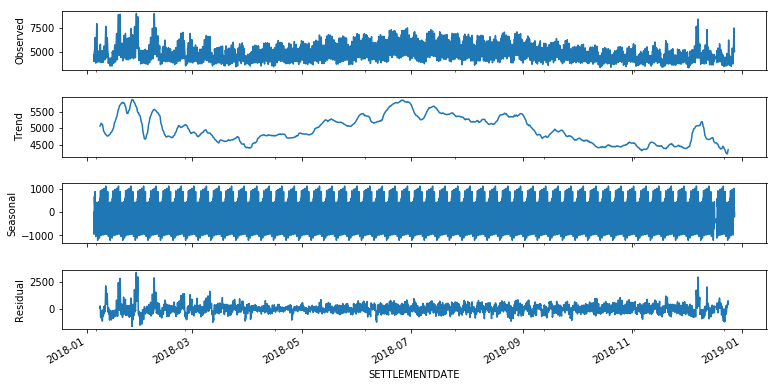

In [128]:
nweekly = seasonal_decompose(target.VIC1, freq = 48*7)
fig = plt.figure()  
fig = nweekly.plot()  
fig.set_size_inches(12, 6)
plt.show()

In [129]:
newtarget['wtrend'] = nweekly.trend
newtarget['wseason'] = nweekly.seasonal
newtarget['wresid'] = nweekly.resid
newtarget.dropna(inplace=True)
newtarget.head()

,VIC1,wtrend,wseason,wresid
SETTLEMENTDATE,,,,
2018-01-08 12:00:00,5374.59,5063.031696,258.532141,53.026162
2018-01-08 12:30:00,5452.23,5064.875149,242.156505,145.198346
2018-01-08 13:00:00,5526.87,5066.606324,245.095233,215.168443
2018-01-08 13:30:00,5619.32,5068.173244,285.823768,265.322988
2018-01-08 14:00:00,5558.61,5069.598348,305.645357,183.366295


In [116]:
# draw_gridplot(newtarget, columns=['wseason'])

<Figure size 432x288 with 0 Axes>

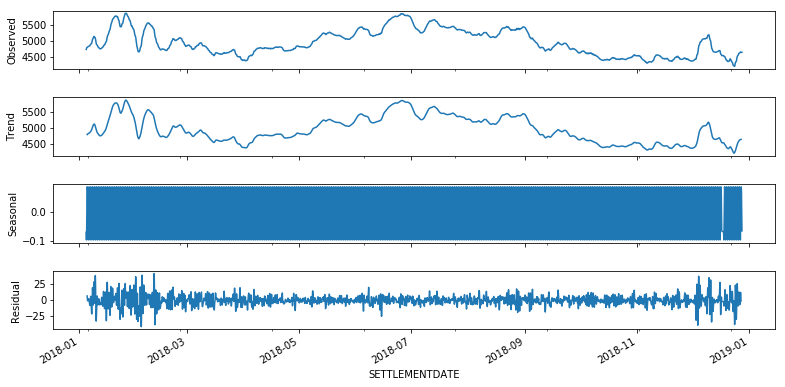

In [115]:
# ndaily = seasonal_decompose(target.wtrend, freq = 48)
# fig = plt.figure()  
# fig = ndaily.plot()  
# fig.set_size_inches(12, 6)
# plt.show()

In [130]:
len(newtarget) / 4

4188.0

In [131]:
newtarget.head()

,VIC1,wtrend,wseason,wresid
SETTLEMENTDATE,,,,
2018-01-08 12:00:00,5374.59,5063.031696,258.532141,53.026162
2018-01-08 12:30:00,5452.23,5064.875149,242.156505,145.198346
2018-01-08 13:00:00,5526.87,5066.606324,245.095233,215.168443
2018-01-08 13:30:00,5619.32,5068.173244,285.823768,265.322988
2018-01-08 14:00:00,5558.61,5069.598348,305.645357,183.366295


In [132]:
newtarget['w_unexp'] = newtarget[['wtrend','wresid']].sum(axis=1)
newtarget.head(2)

,VIC1,wtrend,wseason,wresid,w_unexp
SETTLEMENTDATE,,,,,
2018-01-08 12:00:00,5374.59,5063.031696,258.532141,53.026162,5116.057859
2018-01-08 12:30:00,5452.23,5064.875149,242.156505,145.198346,5210.073495


<Figure size 432x288 with 0 Axes>

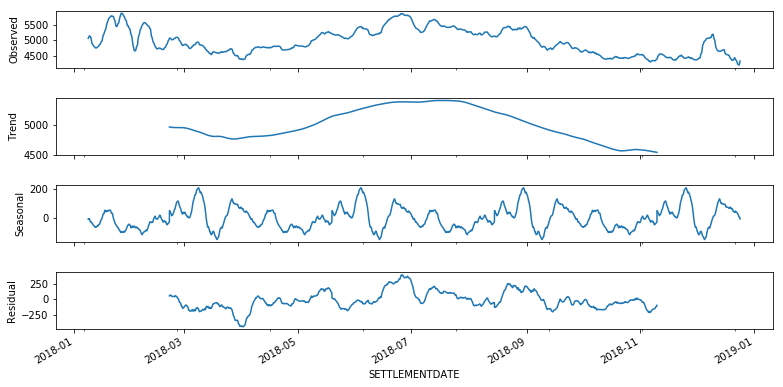

In [134]:
sumwin = seasonal_decompose(newtarget.wtrend, freq=int(len(newtarget) / 4))
fig = plt.figure()  
fig = sumwin.plot()  
fig.set_size_inches(12, 6)
plt.show()

In [135]:
newtarget['strend'] = sumwin.trend
newtarget['sseason'] = sumwin.seasonal
newtarget['sresid'] = sumwin.resid
newtarget.dropna(inplace=True)
newtarget.head()

,VIC1,wtrend,wseason,wresid,w_unexp,strend,sseason,sresid
SETTLEMENTDATE,,,,,,,,
2018-02-21 03:00:00,3956.40,5067.519717,-947.154548,-163.965169,4903.554548,4963.634021,48.918366,54.967331
2018-02-21 03:30:00,3959.12,5069.778705,-976.017175,-134.641530,4935.137175,4963.519920,49.324819,56.933966
2018-02-21 04:00:00,3981.98,5071.549911,-981.510754,-108.059157,4963.490754,4963.406002,49.650567,58.493342
2018-02-21 04:30:00,4070.44,5072.788170,-916.464964,-85.883205,4986.904964,4963.292395,49.777158,59.718617
2018-02-21 05:00:00,4222.74,5073.532336,-815.857593,-34.934743,5038.597593,4963.179208,49.692601,60.660526


In [138]:
newtarget['unexplained'] = newtarget[['sseason','sresid','wresid']].sum(axis=1)
newtarget['Total'] = newtarget[['strend','wseason','unexplained']].sum(axis=1)
newtarget.head(3)

,VIC1,wtrend,wseason,wresid,w_unexp,strend,sseason,sresid,unexplained,Total
SETTLEMENTDATE,,,,,,,,,,
2018-02-21 03:00:00,3956.40,5067.519717,-947.154548,-163.965169,4903.554548,4963.634021,48.918366,54.967331,-60.079472,3956.40
2018-02-21 03:30:00,3959.12,5069.778705,-976.017175,-134.641530,4935.137175,4963.519920,49.324819,56.933966,-28.382745,3959.12
2018-02-21 04:00:00,3981.98,5071.549911,-981.510754,-108.059157,4963.490754,4963.406002,49.650567,58.493342,0.084752,3981.98


In [139]:
newtarget[abs(newtarget.VIC1 - newtarget.Total) > 0.01]

,VIC1,wtrend,wseason,wresid,w_unexp,strend,sseason,sresid,unexplained,Total
SETTLEMENTDATE,,,,,,,,,,


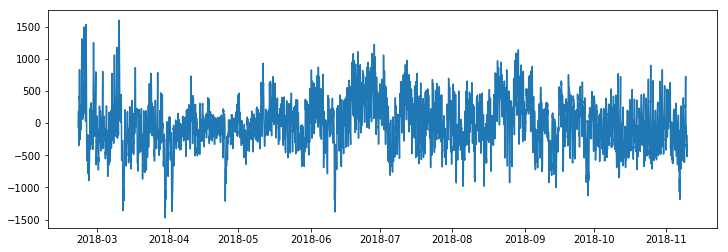

In [145]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(newtarget.index, newtarget.unexplained)
plt.show()

In [149]:
vfeatures = dfvic[dfvic.index.isin(newtarget.index)].drop(columns=['Date','Year'])
vfeatures.head()

,Hour_of_day,shoulder,summer,winter,workdayVIC,MILDURA-AIRPORT_MinT_76031,CAPE-NELSON_MaxT_90184,MORWELL_MaxT_85280,MELBOURNE-AIRPORT_MinT_86282,CAPE-NELSON_MinT_90184,MILDURA-AIRPORT_MaxT_76031,MELBOURNE-AIRPORT_MaxT_86282,MORWELL_MinT_85280
SETTLEMENTDATE,,,,,,,,,,,,,
2018-02-21 03:00:00,3.0,0,1,0,1.0,22.9,20.1,27.8,13.8,17.3,35.4,29.3,11.5
2018-02-21 03:30:00,3.5,0,1,0,1.0,22.9,20.1,27.8,13.8,17.3,35.4,29.3,11.5
2018-02-21 04:00:00,4.0,0,1,0,1.0,22.9,20.1,27.8,13.8,17.3,35.4,29.3,11.5
2018-02-21 04:30:00,4.5,0,1,0,1.0,22.9,20.1,27.8,13.8,17.3,35.4,29.3,11.5
2018-02-21 05:00:00,5.0,0,1,0,1.0,22.9,20.1,27.8,13.8,17.3,35.4,29.3,11.5


In [151]:
both_for_plot = pd.merge(vfeatures, newtarget[['unexplained']], how='inner', left_index=True, right_index=True)

In [150]:
def multi_scatter(indf, ycol, xcols_list, no_cols=4):

    no_rows = int(np.ceil(len(xcols_list)/no_cols))
    plotlen = int(round((15/no_cols)*no_rows))
    sfig, saxes = plt.subplots(nrows=no_rows, ncols=no_cols, figsize = (15,plotlen), sharey=True)

    saxes = saxes.flatten()

    for ct, a in enumerate(xcols_list):
        saxes[ct].scatter(x=indf[a], y= indf[ycol])
        saxes[ct].set(title=f"{ycol} vs {a}")

    sfig.subplots_adjust(wspace= 0.2, hspace=0.35)
#     plt.savefig("correlation-plots.png")
    plt.show()

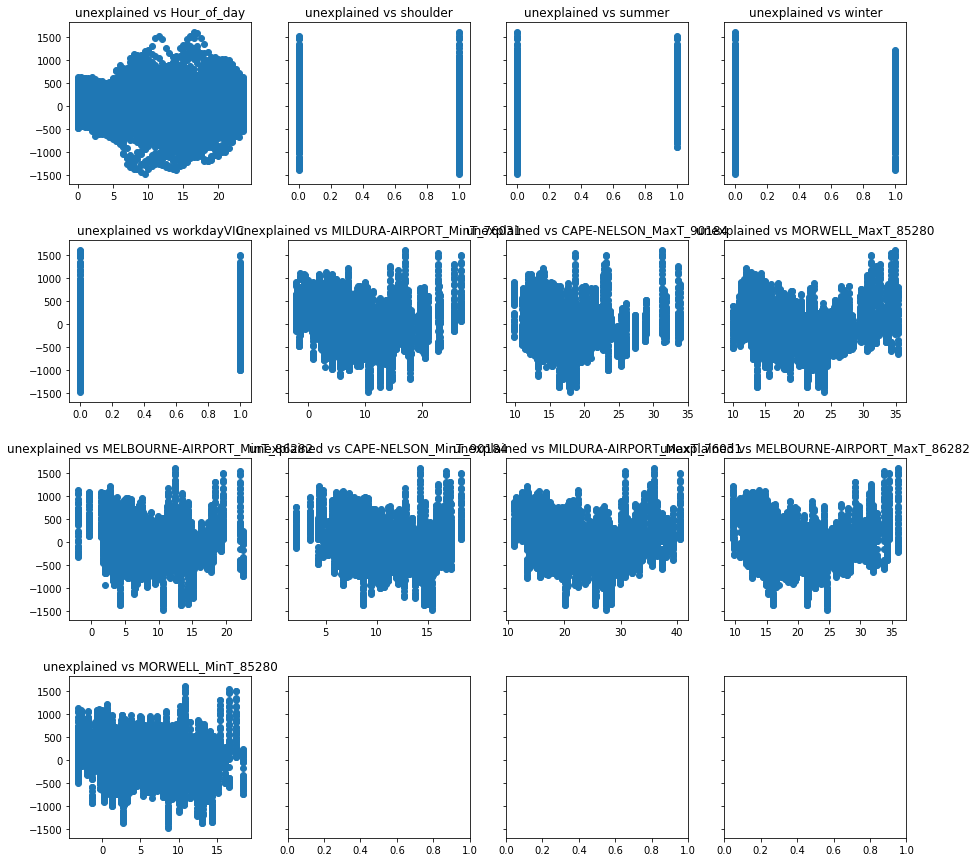

In [152]:
multi_scatter(both_for_plot, ycol='unexplained', xcols_list=vfeatures.columns)

In [154]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

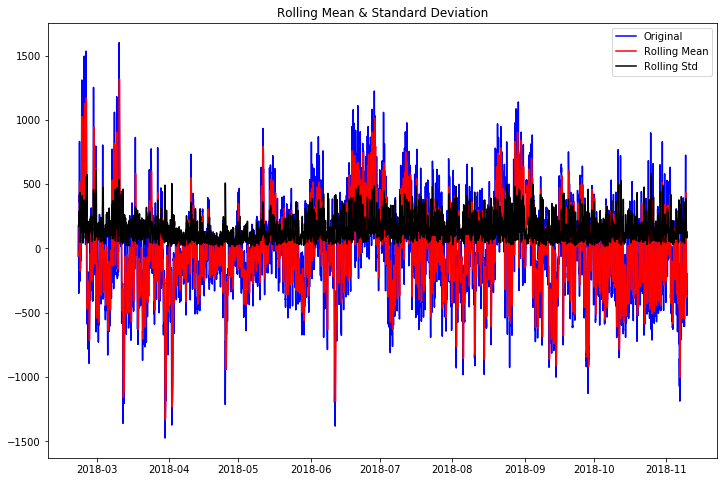

Results of Dickey-Fuller Test:
Test Statistic                -6.205772e+00
p-value                        5.662807e-08
#Lags Used                     4.100000e+01
Number of Observations Used    1.252200e+04
Critical Value (1%)           -3.430872e+00
Critical Value (5%)           -2.861771e+00
Critical Value (10%)          -2.566893e+00
dtype: float64


In [155]:
test_stationarity(newtarget.unexplained)

In [153]:
# Variables
endog = newtarget.unexplained
exog = vfeatures

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

/Users/pat.hearps/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)
/Users/pat.hearps/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:            unexplained   No. Observations:                12564
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -70406.830
Date:                Wed, 06 Mar 2019   AIC                         140845.659
Time:                        11:07:05   BIC                         140964.677
Sample:                    02-21-2018   HQIC                        140885.493
                         - 11-09-2018                                         
Covariance Type:                  opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Hour_of_day                     -0.2304      0.200     -1.154      0.248      -0.622       0.161
shoulder                       122.9103     45.533      2.699      0.007     

In [156]:
yhat = res.predict(start=newtarget.index.min(), end=newtarget.index.max())

In [160]:
newtarget.head()

,VIC1,wtrend,wseason,wresid,w_unexp,strend,sseason,sresid,unexplained,Total,Month,mthname
SETTLEMENTDATE,,,,,,,,,,,,
2018-02-21 03:00:00,3956.40,5067.519717,-947.154548,-163.965169,4903.554548,4963.634021,48.918366,54.967331,-60.079472,3956.40,2,February
2018-02-21 03:30:00,3959.12,5069.778705,-976.017175,-134.641530,4935.137175,4963.519920,49.324819,56.933966,-28.382745,3959.12,2,February
2018-02-21 04:00:00,3981.98,5071.549911,-981.510754,-108.059157,4963.490754,4963.406002,49.650567,58.493342,0.084752,3981.98,2,February
2018-02-21 04:30:00,4070.44,5072.788170,-916.464964,-85.883205,4986.904964,4963.292395,49.777158,59.718617,23.612569,4070.44,2,February
2018-02-21 05:00:00,4222.74,5073.532336,-815.857593,-34.934743,5038.597593,4963.179208,49.692601,60.660526,75.418384,4222.74,2,February


In [161]:
newtarget['pred_unexp'] = yhat
newtarget.head(3)

,VIC1,wtrend,wseason,wresid,w_unexp,strend,sseason,sresid,unexplained,Total,Month,mthname,pred_unexp
SETTLEMENTDATE,,,,,,,,,,,,,
2018-02-21 03:00:00,3956.40,5067.519717,-947.154548,-163.965169,4903.554548,4963.634021,48.918366,54.967331,-60.079472,3956.40,2,February,371.716930
2018-02-21 03:30:00,3959.12,5069.778705,-976.017175,-134.641530,4935.137175,4963.519920,49.324819,56.933966,-28.382745,3959.12,2,February,-50.925100
2018-02-21 04:00:00,3981.98,5071.549911,-981.510754,-108.059157,4963.490754,4963.406002,49.650567,58.493342,0.084752,3981.98,2,February,-3.475451


In [198]:
newtarget.index.max()

Timestamp('2018-11-09 20:30:00')

In [199]:
forecast = res.get_prediction(start=newtarget.index.min(), end=newtarget.index.max(), dynamic = True)

In [203]:
forecast.prediction_results.results

In [188]:
# newtarget['forecast'] = forecast.prediction_results()

TypeError: 'PredictionResults' object is not callable

In [206]:
[r for r in forecast.prediction_results.results]

TypeError: 'FilterResults' object is not iterable

In [189]:
newtarget

,VIC1,wtrend,wseason,wresid,w_unexp,strend,sseason,sresid,unexplained,Total,Month,mthname,pred_unexp,forecast
SETTLEMENTDATE,,,,,,,,,,,,,,
2018-02-21 03:00:00,3956.40,5067.519717,-947.154548,-163.965169,4903.554548,4963.634021,48.918366,54.967331,-60.079472,3956.40,2,February,371.716930,<statsmodels.tsa.statespace.kalman_filter.Pred...
2018-02-21 03:30:00,3959.12,5069.778705,-976.017175,-134.641530,4935.137175,4963.519920,49.324819,56.933966,-28.382745,3959.12,2,February,-50.925100,<statsmodels.tsa.statespace.kalman_filter.Pred...
2018-02-21 04:00:00,3981.98,5071.549911,-981.510754,-108.059157,4963.490754,4963.406002,49.650567,58.493342,0.084752,3981.98,2,February,-3.475451,<statsmodels.tsa.statespace.kalman_filter.Pred...
2018-02-21 04:30:00,4070.44,5072.788170,-916.464964,-85.883205,4986.904964,4963.292395,49.777158,59.718617,23.612569,4070.44,2,February,16.275137,<statsmodels.tsa.statespace.kalman_filter.Pred...
2018-02-21 05:00:00,4222.74,5073.532336,-815.857593,-34.934743,5038.597593,4963.179208,49.692601,60.660526,75.418384,4222.74,2,February,40.916474,<statsmodels.tsa.statespace.kalman_filter.Pred...
2018-02-21 05:30:00,4532.12,5073.919182,-576.643935,34.844754,5108.763935,4963.066522,49.523792,61.328867,145.697413,4532.12,2,February,105.006114,<statsmodels.tsa.statespace.kalman_filter.Pred...
2018-02-21 06:00:00,4827.73,5074.017128,-318.919424,72.632296,5146.649424,4962.954393,49.359734,61.703001,183.695030,4827.73,2,February,175.848494,<statsmodels.tsa.statespace.kalman_filter.Pred...
2018-02-21 06:30:00,5183.24,5073.858036,71.600333,37.781631,5111.639667,4962.842855,49.181114,61.834067,148.796812,5183.24,2,February,195.048331,<statsmodels.tsa.statespace.kalman_filter.Pred...
2018-02-21 07:00:00,5388.28,5073.608378,397.449493,-82.777871,4990.830507,4962.731925,48.948939,61.927514,28.098581,5388.28,2,February,132.969898,<statsmodels.tsa.statespace.kalman_filter.Pred...


In [184]:
p = figure(x_axis_type='datetime', plot_width = 850, plot_height = 400)

p.line(newtarget.index, newtarget.unexplained, color='blue')
p.line(newtarget.index, newtarget.pred_unexp, color='pink')
p.line(newtarget.index, newtarget.forecast, color='green')

show(p)